## 1. Setting libraries and spark session

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when, round
import matplotlib.pyplot as plt
import numpy as np

In [17]:
spark = SparkSession.builder.appName("Reports").getOrCreate()

In [18]:
df = spark.read.csv("dataset.csv", header=True, inferSchema=True)
df.show(2000)

+------------+-------------+--------+--------------+-----------+-----------------+----------+----------------+-----------+-------+--------+--------------------+-----------+---------+---------+----------------+----------------+
|summary_date|       app_id|app_type|      app_name|campaign_id|    campaign_name|     ad_id|         ad_name|impressions| clicks|installs|               spend| event_name|events_d0|events_d7|unique_events_d0|unique_events_d7|
+------------+-------------+--------+--------------+-----------+-----------------+----------+----------------+-----------+-------+--------+--------------------+-----------+---------+---------+----------------+----------------+
|  2022.06.14|com.super.app| android|Super App 2000|campaign_16|Super campaign 16|ad_16L8hGR|Super AD 16L8hGR|         82|     46|    NULL|             0.00455|super_event|     NULL|     NULL|            NULL|            NULL|
|  2022.07.10|com.super.app| android|Super App 2000|campaign_16|Super campaign 16|ad_16z49oF

## 2. Cleaning Data

In [19]:
# Convert date to ISO format (yyyy-MM-dd)
df = df.withColumn("summary_date", to_date(col("summary_date"), "yyyy.MM.dd"))

In [20]:
# Rename campaign to ensure proper string ordering.
# This transformation adds a leading zero to single-digit campaign numbers (e.g., 'campaign_4' becomes 'campaign_04')
# to allow for correct alphanumeric ordering when sorting by the 'campaign' column.

df = df.withColumn(
    "campaign",
    when(col("campaign_id") == "campaign_4", "campaign_04")
    .when(col("campaign_id") == "campaign_5", "campaign_05")
    .when(col("campaign_id") == "campaign_6", "campaign_06")
    .when(col("campaign_id") == "campaign_9", "campaign_09")
    .otherwise(col("campaign_id"))
)

In [21]:
#round "spend" column to four decimal spaces
df = df.withColumn("spend", round(col("spend"), 4))

In [22]:
#select relevant columns for the report
df = df.select(
    col("summary_date"),
    col("campaign"),
    col("impressions"),
    col("clicks"),
    col("installs"),
    col("spend")
)
df.show(2000)

+------------+-----------+-----------+-------+--------+--------+
|summary_date|   campaign|impressions| clicks|installs|   spend|
+------------+-----------+-----------+-------+--------+--------+
|  2022-06-14|campaign_16|         82|     46|    NULL|  0.0046|
|  2022-07-10|campaign_16|       1942|   1226|       2|  0.8892|
|  2022-07-05|campaign_16|        116|      2|    NULL|  0.0072|
|  2022-06-01|campaign_16|      15550|     18|       4|  0.5246|
|  2022-07-25|campaign_16|          0|      0|       2|     0.0|
|  2022-06-29|campaign_16|        466|    264|       2|  0.2477|
|  2022-06-02|campaign_16|         12|      0|    NULL|  0.0013|
|  2022-07-02|campaign_16|          0|      0|    NULL|     0.0|
|  2022-06-02|campaign_16|         10|      0|    NULL|  7.0E-4|
|  2022-07-27|campaign_16|       7382|    614|    NULL|  2.2152|
|  2022-07-10|campaign_16|         30|      0|    NULL|  0.0046|
|  2022-07-15|campaign_16|        890|     66|    NULL|  0.1866|
|  2022-07-28|campaign_16

In [23]:
#check if inferSchema worked as expected 
df.printSchema()

root
 |-- summary_date: date (nullable = true)
 |-- campaign: string (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- installs: integer (nullable = true)
 |-- spend: double (nullable = true)



In [24]:
#fill null values with zeros
columns_to_fill = ["impressions", "clicks", "spend", "installs"]
df = df.fillna(0, subset=columns_to_fill)
df.show(2000)

+------------+-----------+-----------+-------+--------+--------+
|summary_date|   campaign|impressions| clicks|installs|   spend|
+------------+-----------+-----------+-------+--------+--------+
|  2022-06-14|campaign_16|         82|     46|       0|  0.0046|
|  2022-07-10|campaign_16|       1942|   1226|       2|  0.8892|
|  2022-07-05|campaign_16|        116|      2|       0|  0.0072|
|  2022-06-01|campaign_16|      15550|     18|       4|  0.5246|
|  2022-07-25|campaign_16|          0|      0|       2|     0.0|
|  2022-06-29|campaign_16|        466|    264|       2|  0.2477|
|  2022-06-02|campaign_16|         12|      0|       0|  0.0013|
|  2022-07-02|campaign_16|          0|      0|       0|     0.0|
|  2022-06-02|campaign_16|         10|      0|       0|  7.0E-4|
|  2022-07-27|campaign_16|       7382|    614|       0|  2.2152|
|  2022-07-10|campaign_16|         30|      0|       0|  0.0046|
|  2022-07-15|campaign_16|        890|     66|       0|  0.1866|
|  2022-07-28|campaign_16

## 3. Creating reports

In [25]:
# Create Temporary view to allow execute SQL queries:
df.createOrReplaceTempView("applicationdata")

In [26]:
#Define query for the required report "metrics by campaign"
#Print the report
query = """
SELECT
    campaign,
    SUM(impressions) AS total_impressions,
    SUM(clicks) AS total_clicks,
    SUM(installs) AS total_installs,
    ROUND(SUM(spend), 4) AS total_spend,
    ROUND(AVG(clicks / impressions)*100, 4) AS average_CTR,
    ROUND(AVG(spend / installs), 4) AS average_CPI
FROM applicationdata
GROUP BY campaign
ORDER BY campaign
"""

metrics_by_campaign = spark.sql(query)
metrics_by_campaign.show()

+-----------+-----------------+------------+--------------+-----------+-----------+-----------+
|   campaign|total_impressions|total_clicks|total_installs|total_spend|average_CTR|average_CPI|
+-----------+-----------------+------------+--------------+-----------+-----------+-----------+
|campaign_04|                0|           0|            26|        0.0|       NULL|        0.0|
|campaign_05|                0|           0|          1072|        0.0|       NULL|        0.0|
|campaign_06|         95681244|      847818|          3776|  1422.1973|     0.9809|     0.5185|
|campaign_09|                0|           0|        541224|        0.0|       NULL|        0.0|
|campaign_10|                0|     5429764|        213682|   57194.67|       NULL|    26.1424|
|campaign_13|                0|           0|             2|        0.0|       NULL|        0.0|
|campaign_16|        245177026|     2132984|         28776| 18314.6229|     15.302|     1.6512|
+-----------+-----------------+---------

In [27]:
#Define query for the required report "metrics per campaign" per date
#Print the report
query = """
SELECT
    summary_date,
    campaign,
    SUM(impressions) AS total_impressions,
    SUM(clicks) AS total_clicks,
    SUM(installs) AS total_installs,
    ROUND(SUM(spend), 4) AS total_spend,
    ROUND(AVG(clicks / impressions)*100, 4) AS average_CTR,
    ROUND(AVG(spend / installs), 4) AS average_CPI
FROM applicationdata
GROUP BY summary_date, campaign
ORDER BY summary_date, campaign
"""

metrics_by_date = spark.sql(query)
metrics_by_date.show(2000)

+------------+-----------+-----------------+------------+--------------+-----------+-----------+-----------+
|summary_date|   campaign|total_impressions|total_clicks|total_installs|total_spend|average_CTR|average_CPI|
+------------+-----------+-----------------+------------+--------------+-----------+-----------+-----------+
|  2022-06-01|campaign_06|          2004048|        6768|            18|     9.2659|     0.3377|     0.5148|
|  2022-06-01|campaign_10|                0|      590558|         17316|     468.91|       NULL|     0.0271|
|  2022-06-01|campaign_13|                0|           0|             2|        0.0|       NULL|        0.0|
|  2022-06-01|campaign_16|          3363808|        4074|           766|   172.6419|     3.5559|     0.1974|
|  2022-06-02|campaign_06|           520026|        5268|             6|    12.1898|      1.013|     2.0316|
|  2022-06-02|campaign_10|                0|       28844|         13206|     947.31|       NULL|     0.0717|
|  2022-06-02|campa

## 4. Visualize reports

In [28]:
#Convert spark dataframes to pandas dataframes to allow using matplotlib
metrics_by_campaign_pd = metrics_by_campaign.toPandas()
metrics_by_date_pd = metrics_by_date.toPandas()

#### 4.1 Metrics by Campaign

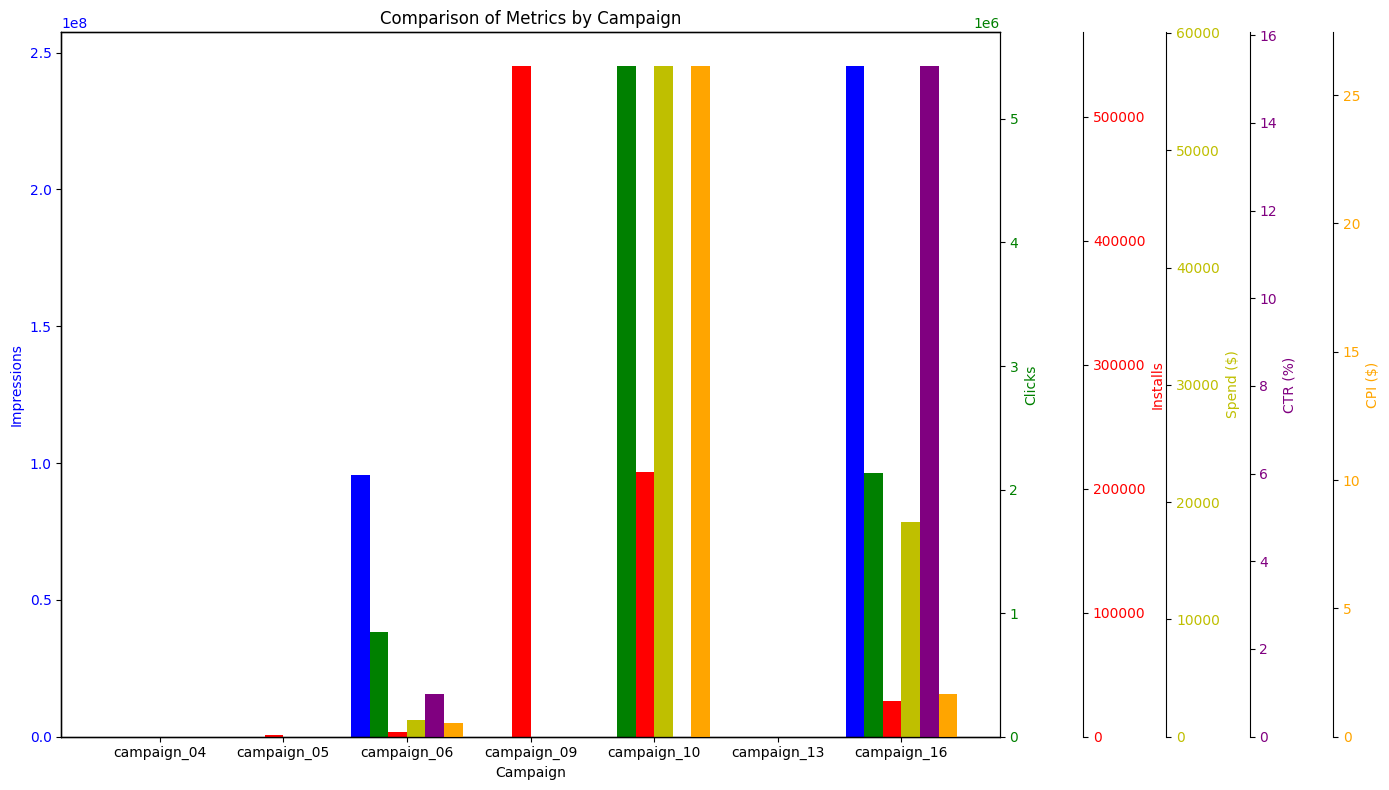

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics to plot
metrics = ['total_impressions', 'total_clicks', 'total_installs', 'total_spend', 'average_CTR', 'average_CTI']
metric_units = ['Impressions', 'Clicks', 'Installs', 'Spend ($)', 'CTR (%)', 'CPI ($)']

# Setting up the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar configuration for the left side (Impressions)
bar_width = 0.15
index = np.arange(len(metrics_by_campaign_pd['campaign']))

# Bars for Impressions (left side)
bars1 = ax1.bar(index, metrics_by_campaign_pd['total_impressions'], bar_width, label='Impressions', color='b')

# Axes and labels configuration for Impressions
ax1.set_xlabel('Campaign')
ax1.set_ylabel('Impressions', color='b')
ax1.set_title('Comparison of Metrics by Campaign')
ax1.set_xticks(index + bar_width * 2.5)
ax1.set_xticklabels(metrics_by_campaign_pd['campaign'])
ax1.tick_params(axis='y', labelcolor='b')

# Create the second axis (secondary axis) for Clicks
ax2 = ax1.twinx()
bars2 = ax2.bar(index + bar_width, metrics_by_campaign_pd['total_clicks'], bar_width, label='Clicks', color='g')
ax2.set_ylabel('Clicks', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Create the third axis (secondary axis) for Installs
ax3 = ax1.twinx()
bars3 = ax3.bar(index + 2 * bar_width, metrics_by_campaign_pd['total_installs'], bar_width, label='Installs', color='r')
ax3.set_ylabel('Installs', color='r')
ax3.spines['right'].set_position(('outward', 60))  # move the axis to the right
ax3.tick_params(axis='y', labelcolor='r')

# Add the fourth axis (secondary axis) for Spend
ax4 = ax1.twinx()
bars4 = ax4.bar(index + 3 * bar_width, metrics_by_campaign_pd['total_spend'], bar_width, label='Spend ($)', color='y')
ax4.set_ylabel('Spend ($)', color='y')
ax4.spines['right'].set_position(('outward', 120))  # move the axis further to the right
ax4.tick_params(axis='y', labelcolor='y')

# Add the fifth axis (secondary axis) for CTR
ax5 = ax1.twinx()
bars5 = ax5.bar(index + 4 * bar_width, metrics_by_campaign_pd['average_CTR'], bar_width, label='CTR (%)', color='purple')
ax5.set_ylabel('CTR (%)', color='purple')
ax5.spines['right'].set_position(('outward', 180))  # move the axis further to the right
ax5.tick_params(axis='y', labelcolor='purple')

# Add the sixth axis (secondary axis) for CPI
ax6 = ax1.twinx()
bars6 = ax6.bar(index + 5 * bar_width, metrics_by_campaign_pd['average_CPI'], bar_width, label='CPI ($)', color='orange')
ax6.set_ylabel('CPI ($)', color='orange')
ax6.spines['right'].set_position(('outward', 240))  # move the axis further to the right
ax6.tick_params(axis='y', labelcolor='orange')

# Adjust layout and display
fig.tight_layout()
plt.show()


### 4.3 Metrics by date by Campaign

Function defined to plot metrics over time for a selected campaign

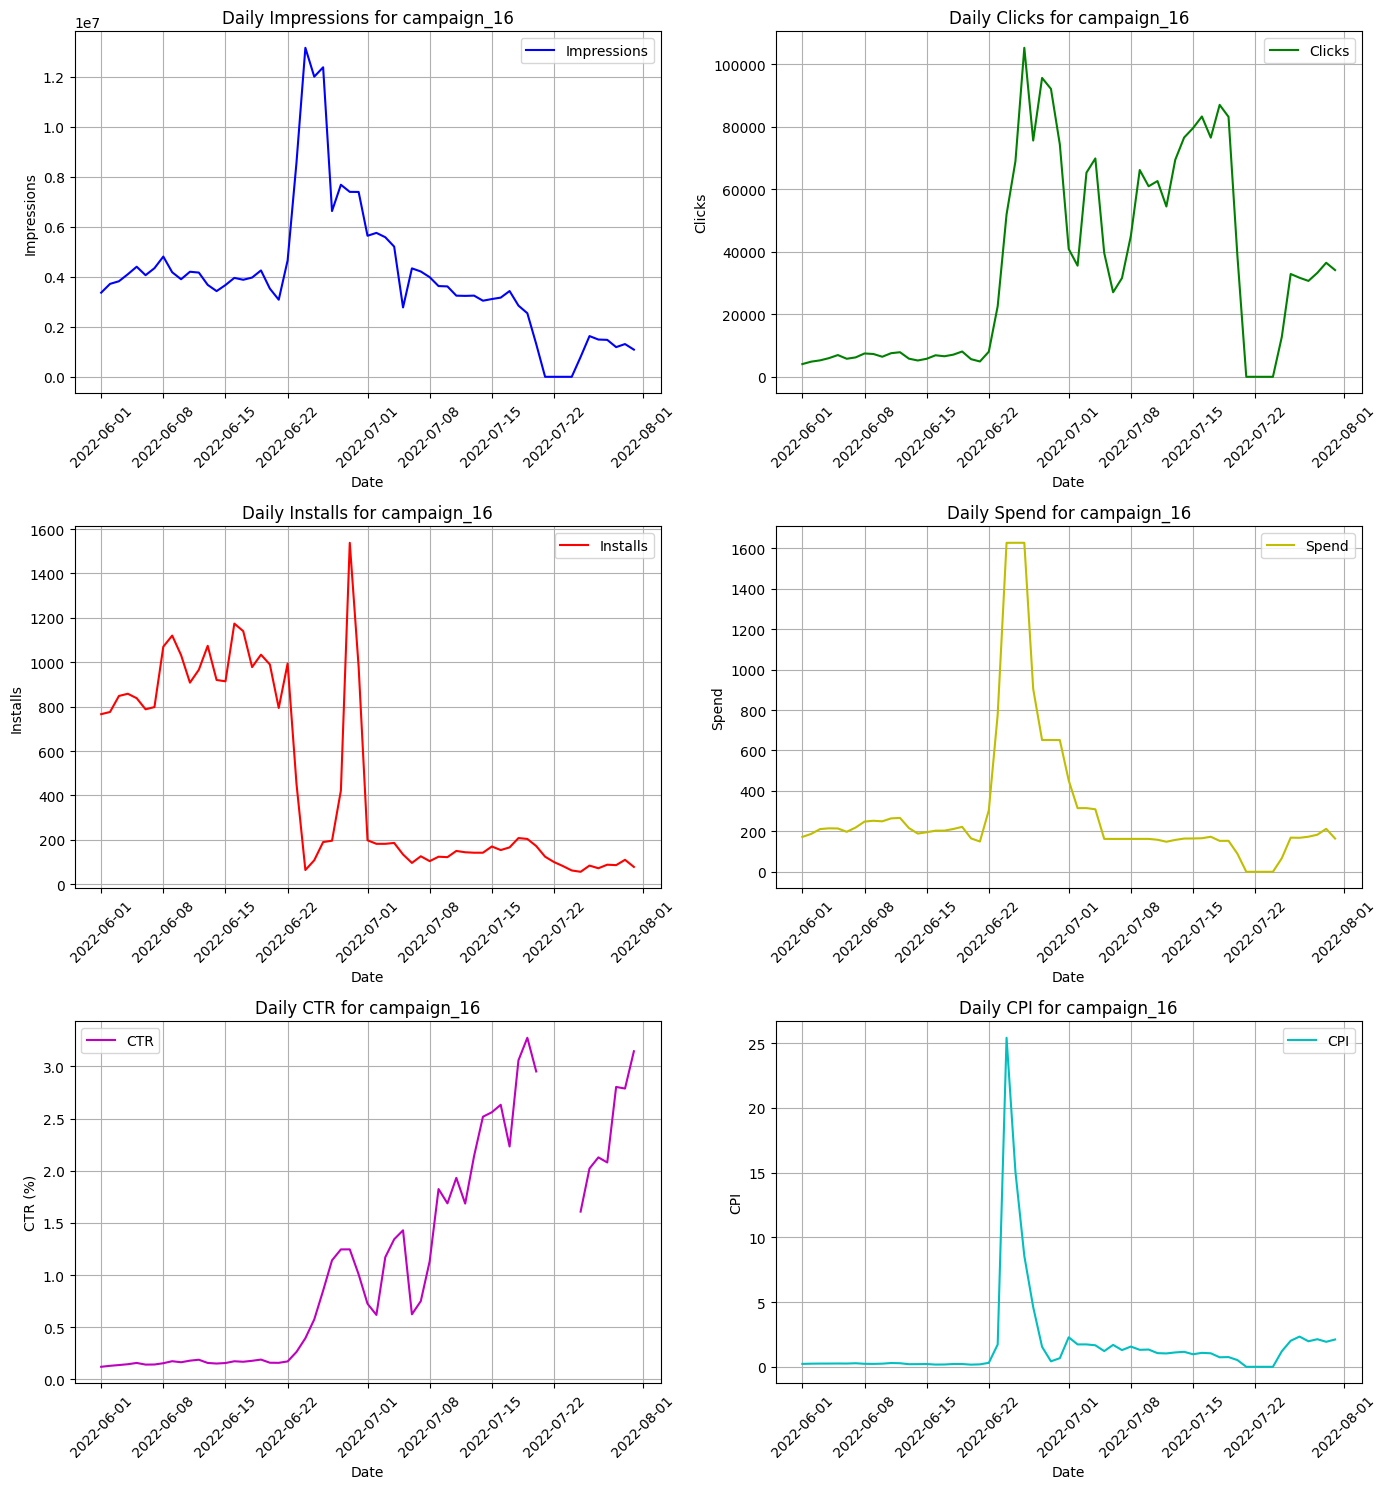

In [30]:
def plot_campaign_metrics(metrics_by_date_pd, campaign_name):
    # Filter data by campaign
    campaign_data = metrics_by_date_pd[metrics_by_date_pd['campaign'] == campaign_name].copy()

    # Calculate additional metrics
    campaign_data.loc[:, 'CTR'] = campaign_data['total_clicks'] / campaign_data['total_impressions'] * 100
    campaign_data.loc[:, 'CPI'] = campaign_data['total_spend'] / campaign_data['total_installs']

    # Set up subplots for each metric
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14, 15))

    # Plot for impressions
    ax1.plot(campaign_data['summary_date'], campaign_data['total_impressions'], label='Impressions', color='b')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Impressions')
    ax1.set_title(f'Daily Impressions for {campaign_name}')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    ax1.grid(True)

    # Plot for clicks
    ax2.plot(campaign_data['summary_date'], campaign_data['total_clicks'], label='Clicks', color='g')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Clicks')
    ax2.set_title(f'Daily Clicks for {campaign_name}')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()
    ax2.grid(True)

    # Plot for installs
    ax3.plot(campaign_data['summary_date'], campaign_data['total_installs'], label='Installs', color='r')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Installs')
    ax3.set_title(f'Daily Installs for {campaign_name}')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend()
    ax3.grid(True)

    # Plot for spend
    ax4.plot(campaign_data['summary_date'], campaign_data['total_spend'], label='Spend', color='y')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Spend')
    ax4.set_title(f'Daily Spend for {campaign_name}')
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend()
    ax4.grid(True)

    # Plot for CTR
    ax5.plot(campaign_data['summary_date'], campaign_data['CTR'], label='CTR', color='m')
    ax5.set_xlabel('Date')
    ax5.set_ylabel('CTR (%)')
    ax5.set_title(f'Daily CTR for {campaign_name}')
    ax5.tick_params(axis='x', rotation=45)
    ax5.legend()
    ax5.grid(True)

    # Plot for CPI
    ax6.plot(campaign_data['summary_date'], campaign_data['CPI'], label='CPI', color='c')
    ax6.set_xlabel('Date')
    ax6.set_ylabel('CPI')
    ax6.set_title(f'Daily CPI for {campaign_name}')
    ax6.tick_params(axis='x', rotation=45)
    ax6.legend()
    ax6.grid(True)

    fig.tight_layout()
    plt.show()

# Sample:
plot_campaign_metrics(metrics_by_date_pd, 'campaign_16')
